In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

# feat means feature here
# bin means histogram bin: the hue range (0~360) is divided by `bin` equal intervals.


# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = np.linspace(5e-7, 5e-6, 10)
regularization_strengths = np.linspace(5e4, 5e5, 10)

results = {}
best_val = -1
best_softmax = Softmax()

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss = softmax.train(X_train_feats, y_train,learning_rate=lr,reg=reg)
        y_train_pred = softmax.predict(X_train_feats)
        y_val_pred = softmax.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, validation_accuracy)
        if best_val < validation_accuracy:
            best_val = validation_accuracy
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    if val_accuracy >= .4:
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

m:\Coding\Academic\Stanford-cs231n\assignment1\cs231n\classifiers\softmax.py:88: RuntimeWarning: divide by zero encountered in log
  logp = np.log(p[np.arange(X.shape[0]), y])  # (N, ) shape[0] is sample num N


lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.415816 val accuracy: 0.418000
lr 5.000000e-07 reg 1.500000e+05 train accuracy: 0.416449 val accuracy: 0.425000
lr 5.000000e-07 reg 2.000000e+05 train accuracy: 0.408429 val accuracy: 0.407000
lr 5.000000e-07 reg 2.500000e+05 train accuracy: 0.415122 val accuracy: 0.427000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.409816 val accuracy: 0.416000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.410673 val accuracy: 0.409000
lr 1.000000e-06 reg 1.500000e+05 train accuracy: 0.417265 val accuracy: 0.416000
lr 1.500000e-06 reg 5.000000e+04 train accuracy: 0.412408 val accuracy: 0.410000
lr 2.500000e-06 reg 5.000000e+04 train accuracy: 0.410571 val accuracy: 0.432000
lr 3.000000e-06 reg 5.000000e+04 train accuracy: 0.403082 val accuracy: 0.410000
lr 4.000000e-06 reg 5.000000e+04 train accuracy: 0.401082 val accuracy: 0.408000
best validation accuracy achieved: 0.432000


In [14]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.426


In [15]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


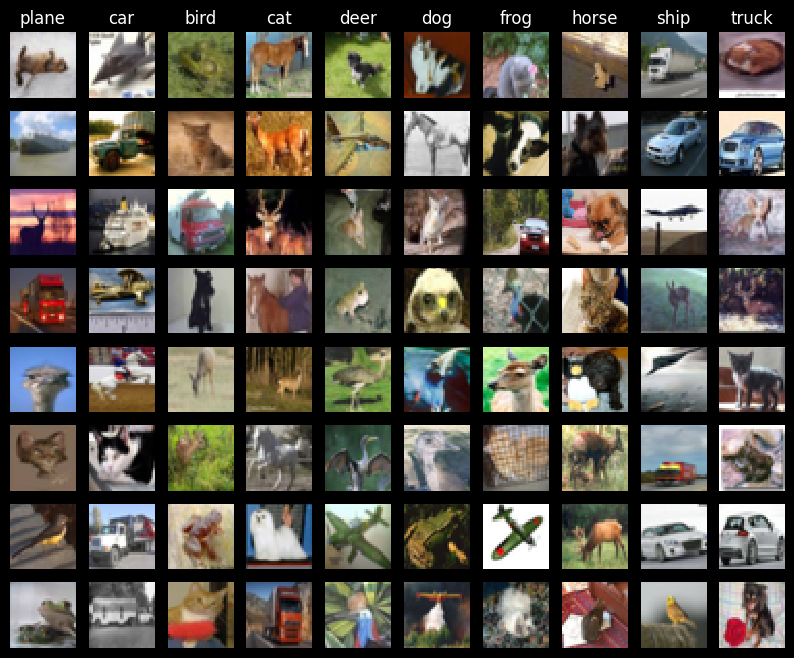

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

Although those cases are misclassified, they still share some common features with the predicted class. For example, at `bird` case, there are several images that has specific shape, in `deer` case, the background color is mostly green which is similar to grassland where deers usually live. 



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [37]:
import warnings
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
# hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# just for language server's type check, which is really annoying
# @{
net = TwoLayerNet(input_dim, 500, num_classes)
best_net = net
best_val_accuracy = -1
best_solver = Solver(net, data)
num_trials = 20
# @}

for i in range(num_trials):
  lr = 10 ** np.random.uniform(-2, 0)
  hidden_size = np.random.choice([50, 100, 150, 200, 300, 500])
  reg = 10 ** np.random.uniform(-6, -2)

  with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")

    try:
      model = TwoLayerNet(input_dim, hidden_size, num_classes, reg=reg)
      solver = Solver(model, data,
                      optim_config={'learning_rate': lr},
                      num_epochs=30,
                      lr_decay=.97,
                      batch_size=200,
                      verbose=False)
      solver.train()

      if len(w) > 0:
        warning_msgs = [str(warning.message) for warning in w]
        print(
          f'Trial {i + 1}: lr={lr:.2e}, hidden={hidden_size}, reg={reg:.2e} -> FAILED')
        print(f'  Warnings: {warning_msgs[0][:50]}... ✗')
        continue

      val_acc = solver.val_acc_history[-1]

      if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_net = model

      print(
        f'Trial {i + 1}: lr={lr:.2e}, hidden={hidden_size}, reg={reg:.2e} -> val_acc={val_acc:.3f} ✓')

    except Exception as e:
      print(
        f'Trial {i + 1}: lr={lr:.2e}, hidden={hidden_size}, reg={reg:.2e} -> EXCEPTION: {type(e).__name__} ✗')
      continue

Trial 1: lr=6.10e-01, hidden=150, reg=1.85e-03 -> val_acc=0.613 ✓
Trial 2: lr=2.19e-01, hidden=300, reg=6.39e-03 -> val_acc=0.587 ✓
Trial 3: lr=1.28e-02, hidden=150, reg=1.13e-03 -> val_acc=0.516 ✓
Trial 4: lr=2.16e-01, hidden=150, reg=9.82e-05 -> val_acc=0.576 ✓
Trial 5: lr=3.86e-02, hidden=150, reg=5.18e-05 -> val_acc=0.576 ✓
Trial 6: lr=2.82e-02, hidden=200, reg=1.20e-03 -> val_acc=0.538 ✓
Trial 7: lr=2.34e-02, hidden=150, reg=8.81e-05 -> val_acc=0.526 ✓
Trial 8: lr=1.27e-01, hidden=50, reg=3.69e-05 -> val_acc=0.575 ✓
Trial 9: lr=3.31e-01, hidden=300, reg=1.40e-04 -> val_acc=0.562 ✓
Trial 10: lr=2.47e-02, hidden=50, reg=7.58e-06 -> val_acc=0.526 ✓
Trial 11: lr=1.71e-02, hidden=150, reg=3.14e-03 -> val_acc=0.515 ✓
Trial 12: lr=2.40e-01, hidden=50, reg=1.22e-03 -> val_acc=0.583 ✓
Trial 13: lr=6.65e-02, hidden=50, reg=6.83e-03 -> val_acc=0.549 ✓
Trial 14: lr=1.05e-02, hidden=50, reg=4.62e-05 -> val_acc=0.498 ✓
Trial 15: lr=1.48e-02, hidden=100, reg=1.44e-06 -> val_acc=0.522 ✓
Trial 16:

In [38]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1) # type: ignore
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.585


In [39]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
